In [1]:
! apt-get install default-jre
!java -version
! pip install h2o
!pip install scikit-learn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  default-jre-headless fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libfontenc1 libxkbfile1 libxtst6 libxxf86dga1 openjdk-11-jre x11-utils
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  default-jre default-jre-headless fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libfontenc1 libxkbfile1 libxtst6 libxxf86dga1 openjdk-11-jre x11-utils
0 upgraded, 12 newly installed, 0 to remove and 45 not upgraded.
Need to get 3,720 kB of archives.
After this operation, 12.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3,042 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxtst6 amd64 2:1.2.3-1build4 [13.4 kB]
Get:3 http://archive.ubuntu.com

In [2]:
import pandas as pd
import numpy as np
from google.colab import files, drive
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import h2o
from h2o.estimators import H2ORandomForestEstimator

%env PYTHONHASHSEED=2024


env: PYTHONHASHSEED=2024


In [3]:
uploaded = files.upload()

Saving recruiting_zeta-disease_training-data_take-home-challenge.xlsx to recruiting_zeta-disease_training-data_take-home-challenge.xlsx
Saving recruiting_zeta-disease_prediction-data_take-home-challenge.xlsx to recruiting_zeta-disease_prediction-data_take-home-challenge.xlsx


# Data Cleaning and Exploration

In [4]:
# load data
df = pd.read_excel("recruiting_zeta-disease_training-data_take-home-challenge.xlsx", sheet_name="2021_zeta-disease_training-data")


In [5]:
df.describe()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,30.985000,172.407500,32.201625,69.565000,85.887500,0.544496,43.121250,4.051250,0.348750
std,13.824025,31.942438,8.549155,19.874784,126.333656,0.348711,30.409949,4.176173,0.476873
min,18.000000,94.000000,0.000000,0.000000,0.000000,0.140800,0.000000,0.000000,0.000000
25%,21.000000,149.000000,27.300000,62.000000,0.000000,0.307800,0.000000,1.000000,0.000000
50%,26.000000,167.000000,32.050000,72.000000,45.000000,0.445300,53.000000,3.000000,0.000000
75%,38.000000,192.000000,36.525000,80.000000,130.000000,0.699800,62.000000,6.000000,1.000000
max,109.000000,308.000000,86.100000,157.000000,1077.000000,3.481300,214.000000,40.000000,1.000000


In [6]:
df.zeta_disease.value_counts() # positive class has ~35% concentration, this is an imbalanced target distribution, though not extreme.

zeta_disease
0    521
1    279
Name: count, dtype: int64

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0, 0.5, 'age'),
  Text(0, 1.5, 'weight'),
  Text(0, 2.5, 'bmi'),
  Text(0, 3.5, 'blood_pressure'),
  Text(0, 4.5, 'insulin_test'),
  Text(0, 5.5, 'liver_stress_test'),
  Text(0, 6.5, 'cardio_stress_test'),
  Text(0, 7.5, 'years_smoking'),
  Text(0, 8.5, 'zeta_disease')])

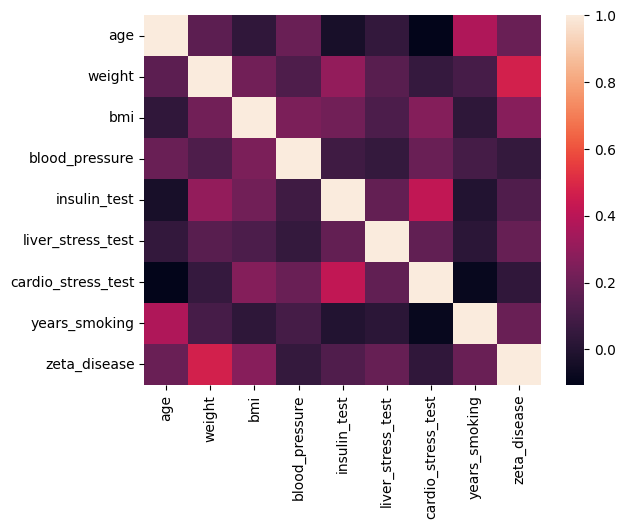

In [7]:
# correlation heatmap
cormat = df.corr()
round(cormat, 2)
ax = sns.heatmap(cormat, annot_kws={"fontsize": 200})
plt.xticks(fontsize=10,rotation=90)
plt.yticks(fontsize=10)


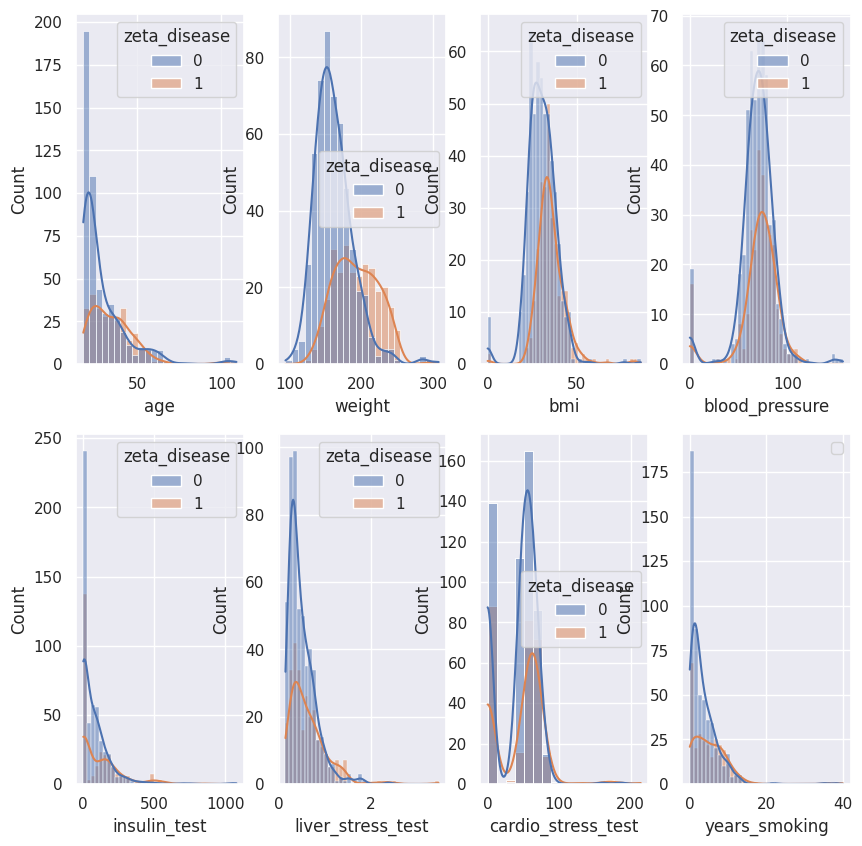

In [8]:
# distribution plot
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 4, figsize=(10, 10))

sns.histplot(data=df, x="age", hue="zeta_disease", kde=True, ax=axs[0, 0])
sns.histplot(data=df, x="weight", hue="zeta_disease", kde=True, ax=axs[0, 1])
sns.histplot(data=df, x="bmi", hue="zeta_disease", kde=True, ax=axs[0, 2])
sns.histplot(data=df, x="blood_pressure", hue="zeta_disease", kde=True, ax=axs[0, 3])
sns.histplot(data=df, x="insulin_test", hue="zeta_disease", kde=True, ax=axs[1, 0])
sns.histplot(data=df, x="liver_stress_test", hue="zeta_disease", kde=True, ax=axs[1, 1])
sns.histplot(data=df, x="cardio_stress_test", hue="zeta_disease", kde=True, ax=axs[1, 2])
sns.histplot(data=df, x="years_smoking", hue="zeta_disease", kde=True, ax=axs[1, 3])

plt.legend()
plt.show()

The distrbution plots and  show that, bmi, blood_pressure, insulin_test and cardio_stress_test have minimum values of 0. Further checking boxplots for better visualization.

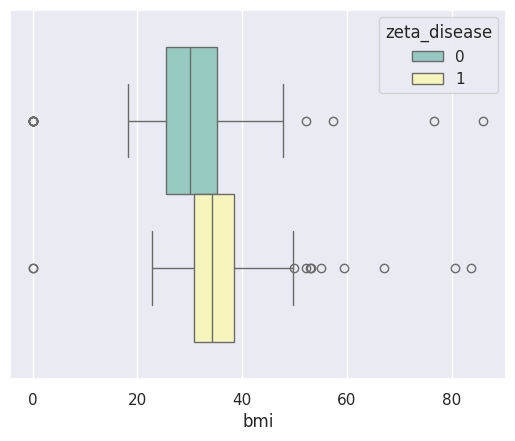

In [9]:
# bmi boxplot
ax = sns.boxplot(x="bmi", hue="zeta_disease", data=df, palette="Set3")

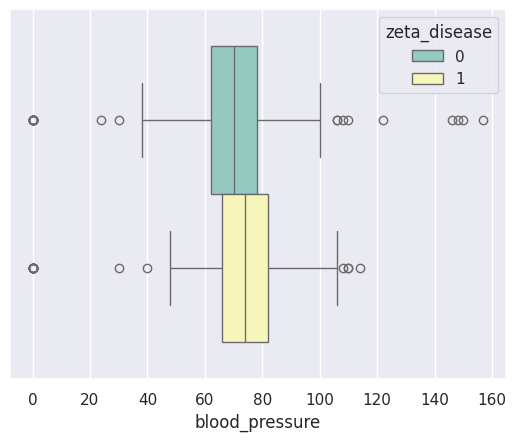

In [10]:
# blood_pressure boxplot
ax = sns.boxplot(x="blood_pressure", hue="zeta_disease", data=df, palette="Set3")

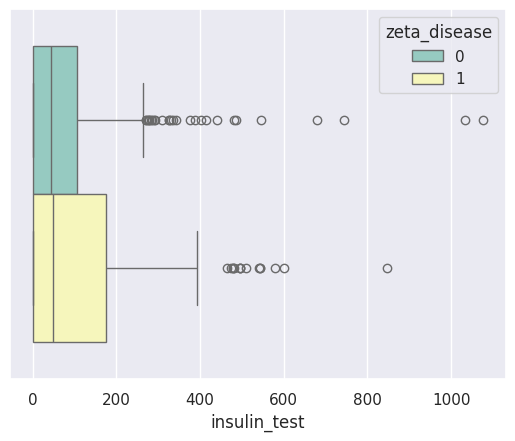

In [11]:
# insulin_test boxplot
ax = sns.boxplot(x="insulin_test", hue="zeta_disease", data=df, palette="Set3")

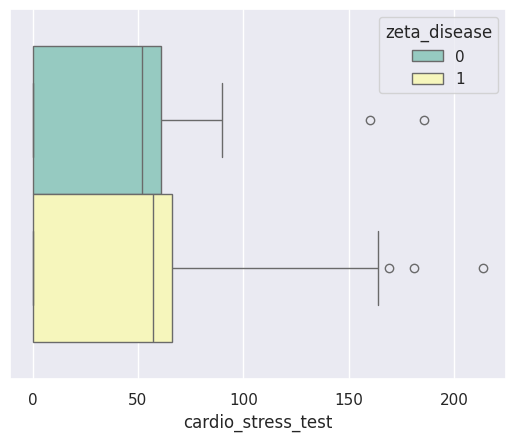

In [12]:
# cardio_stress_test boxplot
ax = sns.boxplot(x="cardio_stress_test", hue="zeta_disease", data=df, palette="Set3")

In [13]:
print(len(df[df.bmi==0])) # small number of missing values, no need for imputation
print(len(df[df.blood_pressure==0])) # small number of missing values, no need for imputation
print(len(df[df.insulin_test==0])) # need extra information to decide whether to impute missing value
print(len(df[df.cardio_stress_test==0])) # need extra information to decide whether to impute missing value

11
35
370
227


**Findings from data exploration:** <br>
It is abnormal to have bmi and blodd_pressure values of 0, so they can be interpreted as missing values. However, the missing percentages of these 2 features are not significant (1.4% and 4.4% missingness), imputation will not be applied to bmi and blodd_pressure. <br>
In terms of insulin_test and cardio_stress_test, there are 44.8% and 28.4% samples have 0s, respectively. However, without knowing the corresponding units, it is hard to understand whether the 0 values are actually missing data or within normal range of a different scale. It is worth exploring imputation for these 2 features.

# Model Training (Baseline without feature imputation or engineering)

In [14]:
h2o.init()

df_h2o = h2o.H2OFrame(df)
df_h2o["zeta_disease"] = df_h2o["zeta_disease"].asfactor()
predictors = df_h2o.columns[:-1]
response = df_h2o.columns[-1]

# Split the dataset into a train and test set:
stratified_split = df_h2o[response].stratified_split(test_frac=0.3,seed=2022)
train = df_h2o[stratified_split=="train"]
test  = df_h2o[stratified_split=="test"]


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp0xxfvqy7
  JVM stdout: /tmp/tmp0xxfvqy7/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp0xxfvqy7/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 22 days
H2O_cluster_name:,H2O_from_python_unknownUser_nkrlhn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [15]:
print(train["zeta_disease"].table())
print(test["zeta_disease"].table())
# training and test data both have ~35% concentration for positive class

  zeta_disease    Count
             0      365
             1      195
[2 rows x 2 columns]

  zeta_disease    Count
             0      156
             1       84
[2 rows x 2 columns]



In [16]:
# define training grid and perform random grid search
rf_params_h2o = {
    "ntrees": list(np.arange(30,70,5)),
    "mtries" : [round(np.sqrt(len(predictors)))],
    "max_depth" : list(np.arange(10,17,2)),
    "min_rows" : list(np.arange(2,7,2)),
    "stopping_metric" : ["AUTO"],
    "stopping_tolerance" : [0.005],
    "sample_rate" : list(np.arange(0.9,1.0,0.01)),
    "score_tree_interval" : [10],
    "nfolds" : [5]
}

grid = pd.DataFrame(sklearn.model_selection.ParameterGrid(rf_params_h2o))
grid = grid.sample(n=20, random_state=2022).reset_index(drop=True)

# model training
model_list = list()
for i in range(len(grid)):
  grid_row = grid.iloc[i]

  model = H2ORandomForestEstimator(ntrees=int(grid_row["ntrees"]),
                                   mtries=int(grid_row["mtries"]),
                                   max_depth=int(grid_row["max_depth"]),
                                   min_rows=int(grid_row["min_rows"]),
                                   nfolds=int(grid_row["nfolds"]),
                                   sample_rate=grid_row["sample_rate"],
                                   seed=2022)
  model.train(x=predictors,
                y=response,
                training_frame=train)
  model_list.append(model)
model_auc = [model.auc(xval=True) for model in model_list]
best_model_idx = model_auc.index(max(model_auc))
best_model = model_list[best_model_idx]

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |███████████████████████

In [17]:
# ROC-AUC for both training and cross-validation set
best_model.auc(train=True, xval=True)

{'train': 0.776576302162656, 'xval': 0.8543097997892519}

In [18]:
# PR-AUC for both training and cross-validation set
best_model.aucpr(train=True, xval=True)

{'train': 0.6244240491159483, 'xval': 0.7421469098644757}

In [19]:
# Model Performance on test set
perf = best_model.model_performance(test)
print(perf)

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.18040952093871318
RMSE: 0.42474641957138753
LogLoss: 0.5533479480685867
Mean Per-Class Error: 0.2632783882783883
AUC: 0.7942612942612942
AUCPR: 0.642786652488801
Gini: 0.5885225885225884

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4388888865709305
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      124  32   0.2051   (32.0/156.0)
1      27   57   0.3214   (27.0/84.0)
Total  151  89   0.2458   (59.0/240.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438889     0.65896   82
max f2                       0.0972222    0.78629   148
max f0point5                 0.725        0.673077  39
max accuracy                 0.725        0.758333  39
max precision                0.972222     1         0
max recall                   0.016666

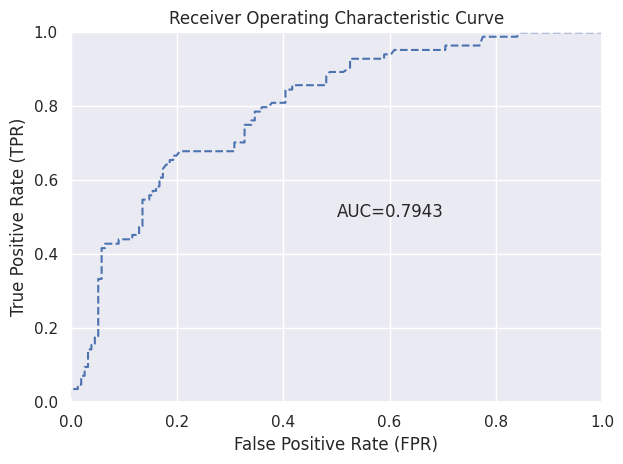

([0.0,
  0.0,
  0.0,
  0.00641025641025641,
  0.01282051282051282,
  0.01282051282051282,
  0.019230769230769232,
  0.019230769230769232,
  0.019230769230769232,
  0.02564102564102564,
  0.02564102564102564,
  0.03205128205128205,
  0.03205128205128205,
  0.03205128205128205,
  0.03205128205128205,
  0.03205128205128205,
  0.038461538461538464,
  0.038461538461538464,
  0.04487179487179487,
  0.04487179487179487,
  0.04487179487179487,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.057692307692307696,
  0.057692307692307696,
  0.057692307692307696,
  0.057692307692307696,
  0.057692307692307696,
  0.057692307692307696,
  0.057692307692307696,
  0.0641025641025641,
  0.0641025641025641,
  0.07051282051282051,
  0.07692307692307693,
  0.08333333333333333,
  0

In [20]:
# Plot ROC Curve
perf.plot()

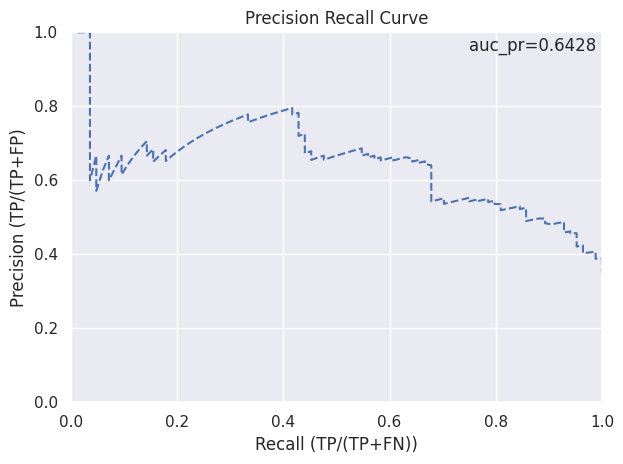

Best threshold for F1 Score: 0.4388888865709305


In [23]:
# Plot Precision-Recall Curve
perf.plot(type="pr")
print(f"Best threshold for F1 Score: {perf.find_threshold_by_max_metric('f1')}")

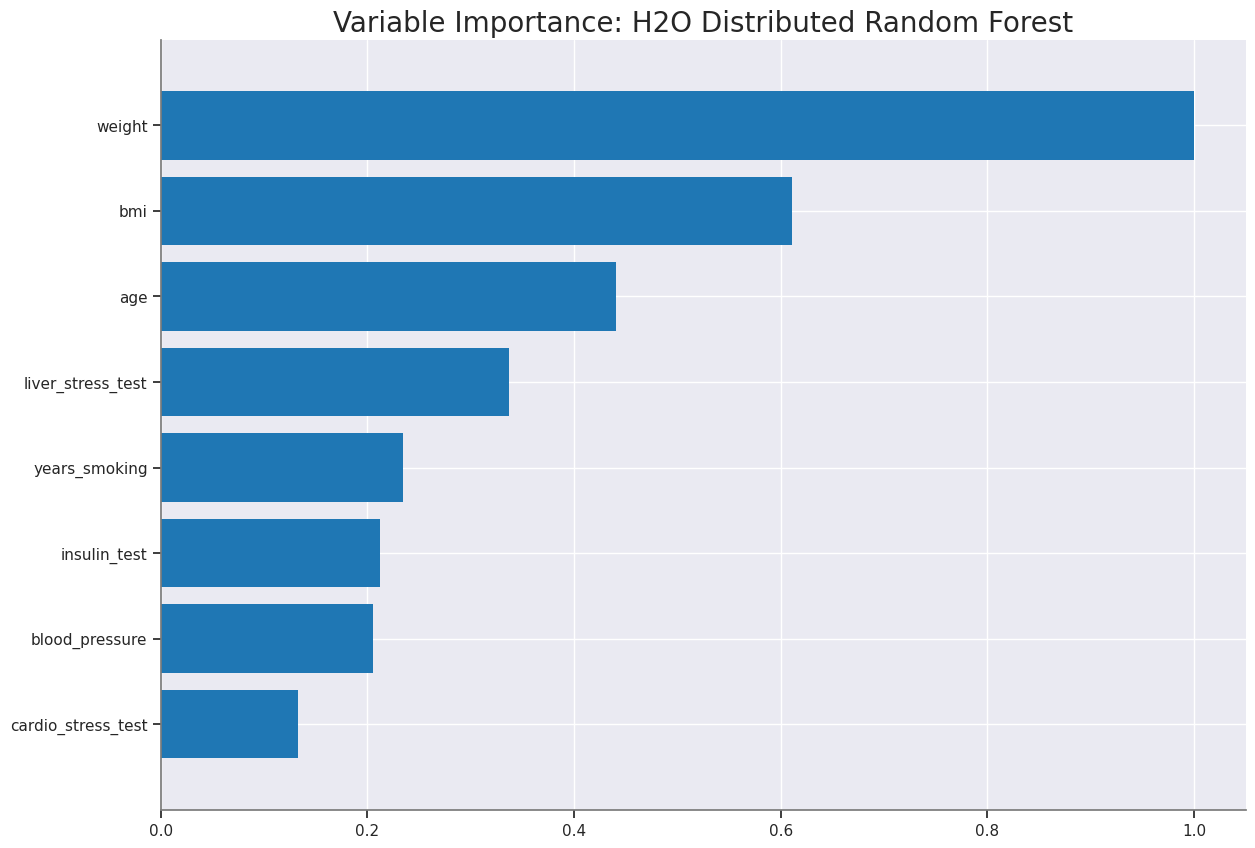

<Figure size 640x480 with 0 Axes>

In [22]:
# Variable Importance
best_model.varimp_plot()

# Model Training - Experiment 1 (Balancing target distribution) <br>
Using hyperparameter [balance_classes](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/balance_classes.html) in H2O, which oversamples the minority classes to balance class distibution when True.

In [24]:
h2o.init()

df_h2o = h2o.H2OFrame(df)
df_h2o["zeta_disease"] = df_h2o["zeta_disease"].asfactor()
predictors = df_h2o.columns[:-1]
response = df_h2o.columns[-1]

# Split the dataset into a train and test set:
stratified_split = df_h2o[response].stratified_split(test_frac=0.3,seed=2022)
train = df_h2o[stratified_split=="train"]
test  = df_h2o[stratified_split=="test"]


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,4 mins 39 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 22 days
H2O_cluster_name:,H2O_from_python_unknownUser_nkrlhn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.102 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [25]:
print(train["zeta_disease"].table())
print(test["zeta_disease"].table())
# training and test data both have ~35% concentration for positive class

  zeta_disease    Count
             0      365
             1      195
[2 rows x 2 columns]

  zeta_disease    Count
             0      156
             1       84
[2 rows x 2 columns]



In [26]:
# define training grid and perform random grid search
rf_params_h2o = {
    "ntrees": list(np.arange(30,70,5)),
    "mtries" : [round(np.sqrt(len(predictors)))],
    "max_depth" : list(np.arange(10,17,2)),
    "min_rows" : list(np.arange(2,7,2)),
    "stopping_metric" : ["AUTO"],
    "stopping_tolerance" : [0.005],
    "sample_rate" : list(np.arange(0.9,1.0,0.01)),
    "score_tree_interval" : [10],
    "nfolds" : [5],
}

grid = pd.DataFrame(sklearn.model_selection.ParameterGrid(rf_params_h2o))
grid = grid.sample(n=20, random_state=2022).reset_index(drop=True)

# model training
model_exp1_list = list()
for i in range(len(grid)):
  grid_row = grid.iloc[i]

  model = H2ORandomForestEstimator(ntrees=int(grid_row["ntrees"]),
                                   mtries=int(grid_row["mtries"]),
                                   max_depth=int(grid_row["max_depth"]),
                                   min_rows=int(grid_row["min_rows"]),
                                   nfolds=int(grid_row["nfolds"]),
                                   sample_rate=grid_row["sample_rate"],
                                   balance_classes=True, # balancing data
                                   seed=2022)
  model.train(x=predictors,
                y=response,
                training_frame=train)
  model_exp1_list.append(model)
model_exp1_auc = [model.auc(xval=True) for model in model_exp1_list]
best_model_exp1_idx = model_exp1_auc.index(max(model_exp1_auc))
best_model_exp1 = model_exp1_list[best_model_exp1_idx]

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |███████████████████████

In [27]:
# ROC-AUC for both training and cross-validation set
best_model_exp1.auc(train=True, xval=True)

{'train': 0.9330670747639133, 'xval': 0.8464207938180541}

In [28]:
# PR-AUC for both training and cross-validation set
best_model_exp1.aucpr(train=True, xval=True)

{'train': 0.8930756539808626, 'xval': 0.7302708473894635}

In [29]:
# Model Performance on test set
perf_exp1 = best_model_exp1.model_performance(test)
print(perf_exp1)

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.1774937772553385
RMSE: 0.42130010355486325
LogLoss: 0.5678848178656565
Mean Per-Class Error: 0.25457875457875456
AUC: 0.7954441391941391
AUCPR: 0.6675891425425543
Gini: 0.5908882783882783

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3091984691177535
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      123  33   0.2115   (33.0/156.0)
1      25   59   0.2976   (25.0/84.0)
Total  148  92   0.2417   (58.0/240.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.309198     0.670455  91
max f2                       0.0695416    0.777096  152
max f0point5                 0.51764      0.694444  59
max accuracy                 0.51764      0.775     59
max precision                0.958873     1         0
max recall                   0.00591

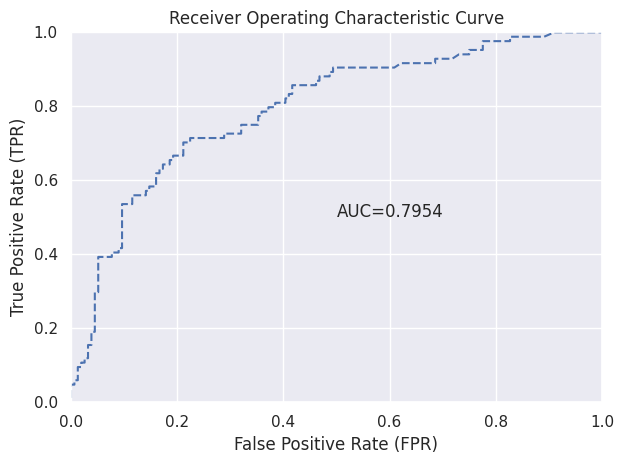

([0.0,
  0.0,
  0.0,
  0.0,
  0.00641025641025641,
  0.00641025641025641,
  0.01282051282051282,
  0.01282051282051282,
  0.01282051282051282,
  0.01282051282051282,
  0.019230769230769232,
  0.019230769230769232,
  0.02564102564102564,
  0.02564102564102564,
  0.03205128205128205,
  0.03205128205128205,
  0.03205128205128205,
  0.03205128205128205,
  0.038461538461538464,
  0.038461538461538464,
  0.038461538461538464,
  0.038461538461538464,
  0.04487179487179487,
  0.04487179487179487,
  0.04487179487179487,
  0.04487179487179487,
  0.04487179487179487,
  0.04487179487179487,
  0.04487179487179487,
  0.04487179487179487,
  0.04487179487179487,
  0.04487179487179487,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.057692307692307696,
  0.0641025641025641,
  0.07051282051282051,
  0.07692307692307693,
  0.07692307692307693,


In [30]:
# Plot ROC Curve
perf_exp1.plot()


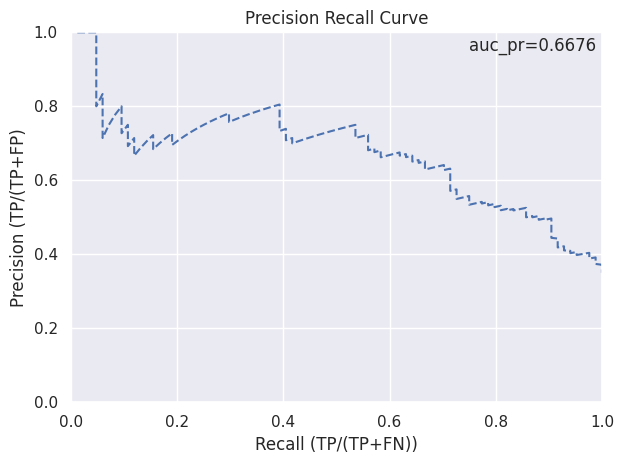

Best threshold for F1 Score: 0.3091984691177535


In [31]:
# Plot Precision-Recall Curve
perf_exp1.plot(type="pr")
print(f"Best threshold for F1 Score: {perf_exp1.find_threshold_by_max_metric('f1')}")

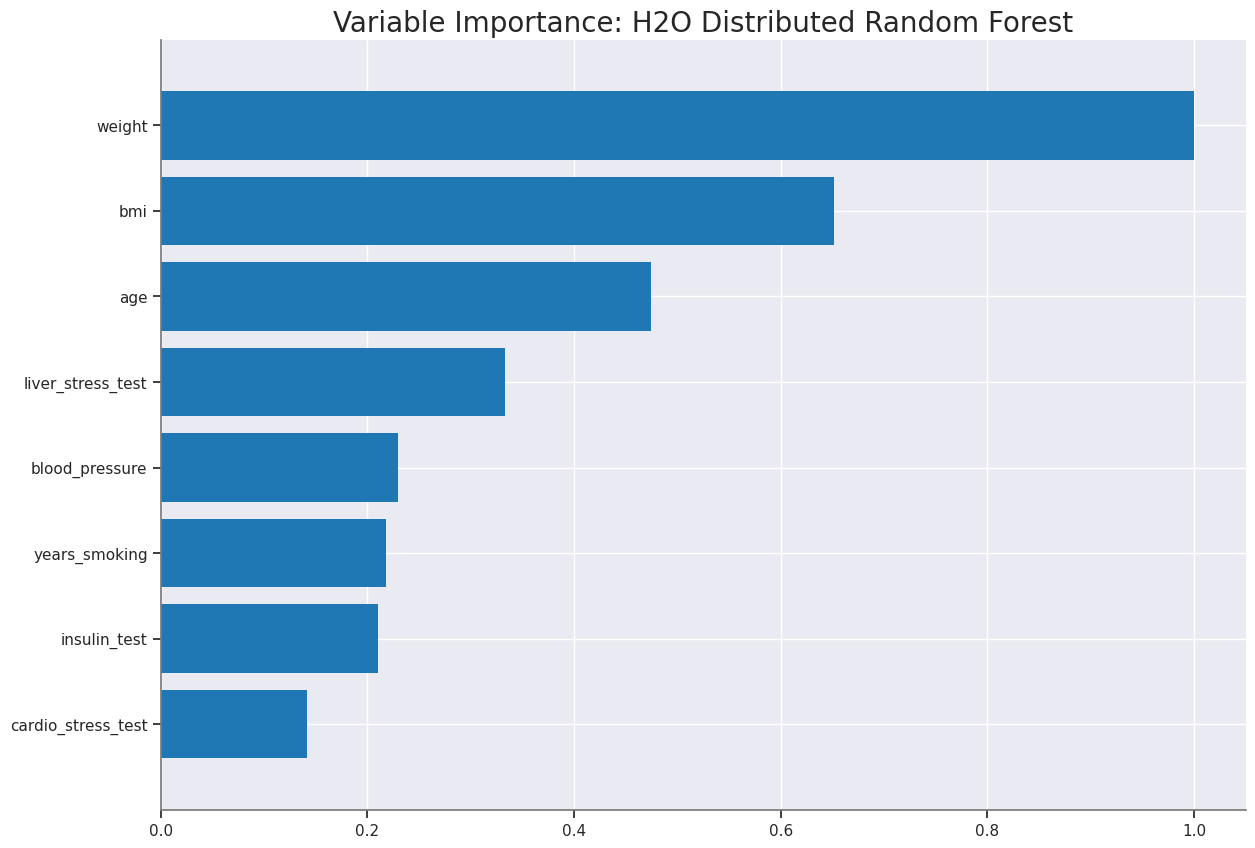

<Figure size 640x480 with 0 Axes>

In [32]:
# Variable Importance
best_model_exp1.varimp_plot()

**Balancing Class Experiment Conclusion:**<br>
By oversample the minority class, the best model ROC-AUC doesn't change much comparing to the baseline, while the PR-AUC increases by 2%, and blood_pressure variable importance bumps up to the 5th position.

# Model Training - Experiment 2 (Impute "missing" data) <br>
Replace 0s with median value of cardio_stress_test and insulin_test

In [33]:
df.loc[df["cardio_stress_test"]==0,"cardio_stress_test"] = np.nan
df.loc[df["insulin_test"]==0,"insulin_test"] = np.nan

In [34]:
h2o.init()

df_h2o = h2o.H2OFrame(df)
df_h2o["zeta_disease"] = df_h2o["zeta_disease"].asfactor()
predictors = df_h2o.columns[:-1]
response = df_h2o.columns[-1]

# Split the dataset into a train and test set:
stratified_split = df_h2o[response].stratified_split(test_frac=0.3,seed=2022)
train = df_h2o[stratified_split=="train"]
test  = df_h2o[stratified_split=="test"]


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,7 mins 37 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 22 days
H2O_cluster_name:,H2O_from_python_unknownUser_nkrlhn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.027 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [35]:
cardio_impute_value = train["cardio_stress_test"].median(na_rm=True)[0]
insulin_impute_value = train["insulin_test"].median(na_rm=True)[0]

In [36]:
cardio_impute_value, insulin_impute_value

(59.0, 130.0)

In [37]:
train_impute = h2o.deep_copy(train, "train_impute")
train_impute[train_impute["cardio_stress_test"].isna(), "cardio_stress_test"] = cardio_impute_value
train_impute[train_impute["insulin_test"].isna(), "insulin_test"] = insulin_impute_value


In [38]:
print(train_impute["zeta_disease"].table())
print(test["zeta_disease"].table())
# training and test data both have ~35% concentration for positive class

  zeta_disease    Count
             0      365
             1      195
[2 rows x 2 columns]

  zeta_disease    Count
             0      156
             1       84
[2 rows x 2 columns]



In [39]:
# define training grid and perform random grid search
rf_params_h2o = {
    "ntrees": list(np.arange(30,70,5)),
    "mtries" : [round(np.sqrt(len(predictors)))],
    "max_depth" : list(np.arange(10,17,2)),
    "min_rows" : list(np.arange(2,7,2)),
    "stopping_metric" : ["AUTO"],
    "stopping_tolerance" : [0.005],
    "sample_rate" : list(np.arange(0.9,1.0,0.01)),
    "score_tree_interval" : [10],
    "nfolds" : [5],
}

grid = pd.DataFrame(sklearn.model_selection.ParameterGrid(rf_params_h2o))
grid = grid.sample(n=20, random_state=2022).reset_index(drop=True)

# model training
model_exp2_list = list()
for i in range(len(grid)):
  grid_row = grid.iloc[i]

  model = H2ORandomForestEstimator(ntrees=int(grid_row["ntrees"]),
                                   mtries=int(grid_row["mtries"]),
                                   max_depth=int(grid_row["max_depth"]),
                                   min_rows=int(grid_row["min_rows"]),
                                   nfolds=int(grid_row["nfolds"]),
                                   sample_rate=grid_row["sample_rate"],
                                   seed=2022)
  model.train(x=predictors,
                y=response,
                training_frame=train_impute)
  model_exp2_list.append(model)
model_exp2_auc = [model.auc(xval=True) for model in model_exp2_list]
best_model_exp2_idx = model_exp2_auc.index(max(model_exp2_auc))
best_model_exp2 = model_exp2_list[best_model_exp2_idx]

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |███████████████████████

In [40]:
# ROC-AUC for both training and cross-validation set
best_model_exp2.auc(train=True, xval=True)

{'train': 0.7539584799437017, 'xval': 0.8476290832455216}

In [41]:
# PR-AUC for both training and cross-validation set
best_model_exp2.aucpr(train=True, xval=True)

{'train': 0.6528724155115603, 'xval': 0.735323992740919}

In [42]:
# Model Performance on test set
perf_exp2 = best_model_exp2.model_performance(test)
print(perf_exp2)

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.17984266120257766
RMSE: 0.42407860262288366
LogLoss: 0.5712654418587294
Mean Per-Class Error: 0.2664835164835165
AUC: 0.7886523199023199
AUCPR: 0.6475236915272669
Gini: 0.5773046398046398

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4093101327235882
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      123  33   0.2115   (33.0/156.0)
1      27   57   0.3214   (27.0/84.0)
Total  150  90   0.25     (60.0/240.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40931      0.655172  87
max f2                       0.0410256    0.763501  185
max f0point5                 0.733242     0.681818  42
max accuracy                 0.733242     0.7625    42
max precision                0.805128     0.818182  30
max recall                   0.0128

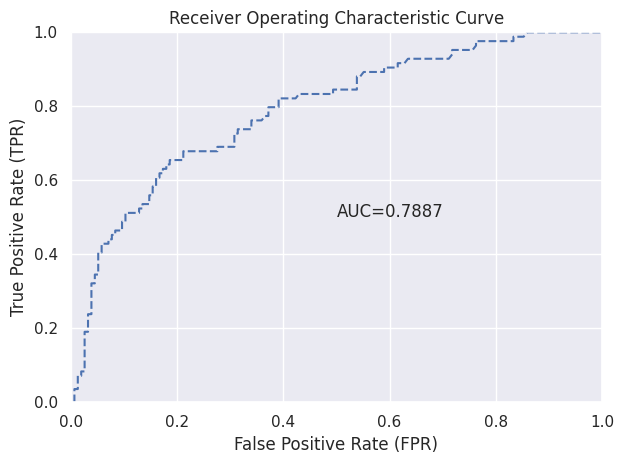

([0.00641025641025641,
  0.00641025641025641,
  0.00641025641025641,
  0.01282051282051282,
  0.01282051282051282,
  0.01282051282051282,
  0.01282051282051282,
  0.019230769230769232,
  0.019230769230769232,
  0.02564102564102564,
  0.02564102564102564,
  0.02564102564102564,
  0.02564102564102564,
  0.02564102564102564,
  0.02564102564102564,
  0.02564102564102564,
  0.02564102564102564,
  0.02564102564102564,
  0.03205128205128205,
  0.03205128205128205,
  0.03205128205128205,
  0.03205128205128205,
  0.03205128205128205,
  0.038461538461538464,
  0.038461538461538464,
  0.038461538461538464,
  0.038461538461538464,
  0.038461538461538464,
  0.038461538461538464,
  0.038461538461538464,
  0.038461538461538464,
  0.04487179487179487,
  0.04487179487179487,
  0.04487179487179487,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.05128205128205128,
  0.057692307692307696,
  0.057692307692307696,
  0.057692307692307696

In [43]:
# Plot ROC Curve
perf_exp2.plot()

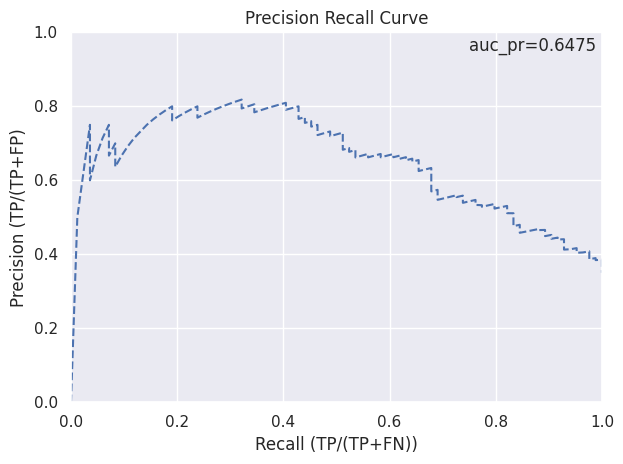

Best threshold for F1 Score: 0.4093101327235882


In [44]:
# Plot Precision-Recall Curve
perf_exp2.plot(type="pr")
print(f"Best threshold for F1 Score: {perf_exp2.find_threshold_by_max_metric('f1')}")

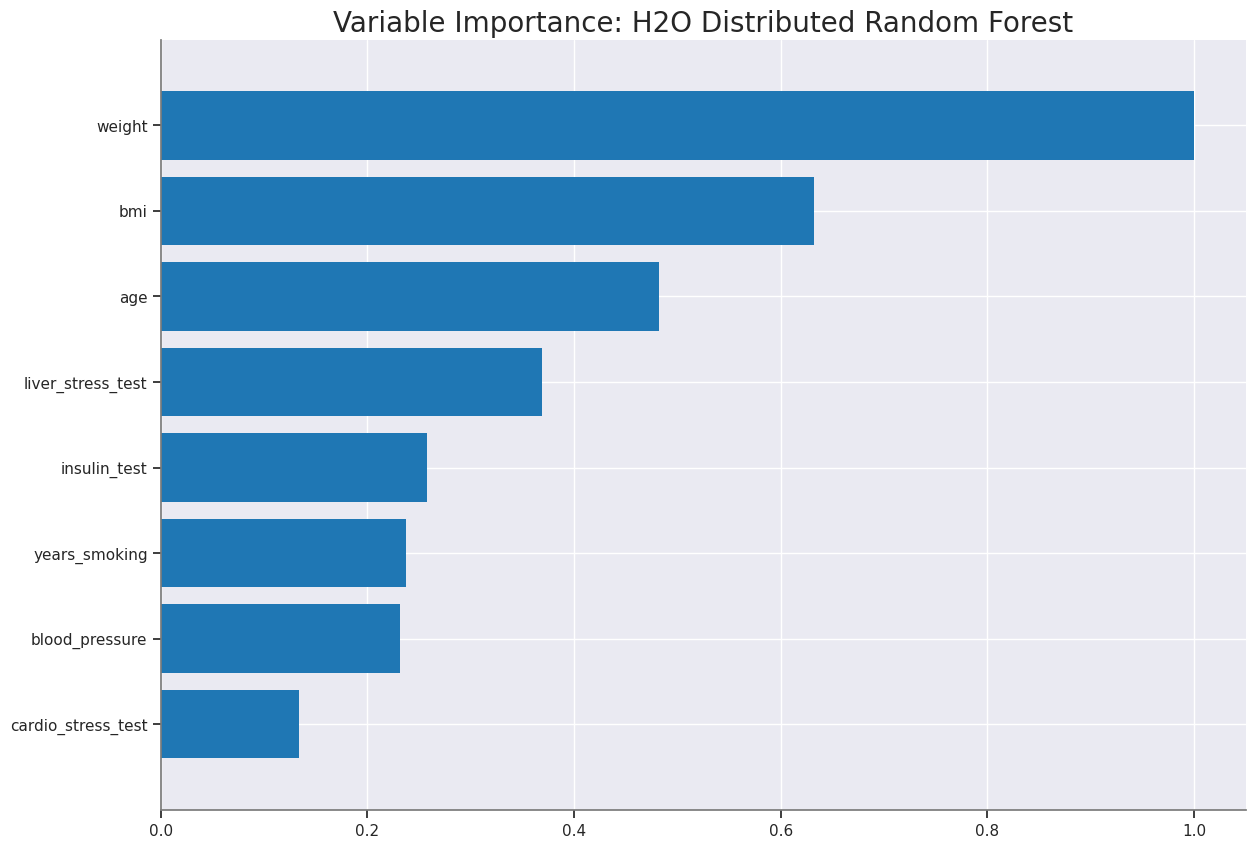

<Figure size 640x480 with 0 Axes>

In [45]:
# Variable Importance
best_model_exp2.varimp_plot()

**Imputation Experiment Conclusion:**<br>
Replacing 0 with median for cardio_stress_test and insulin_test doesn't imporve model performance on test set, instead it decreases the ROC-AUC test performance by 2%. In practice, I personally don't like imputation, since it's vulnerable to data drift.

# Model Training Experiment Conclusion: <br>
Among the 3 model variations (base line and 2 experiments), the model with balanced target distribution has slightly better performance on test set. Thus, the best model from this variation will be used for inferences. In addition, to balance precision and recall, threshold @ best f1 will be chosen to classify positive or negative case during prediction.

# Model Inference

In [46]:
df_inf = pd.read_excel("recruiting_zeta-disease_prediction-data_take-home-challenge.xlsx", sheet_name="2021-01-21_zeta-disease_predict")

In [47]:
df_inf.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,24,151,39.5,69,72,1.3968,56,4,NaN
1,27,179,35.5,89,156,1.6608,43,6,NaN
2,34,147,26.9,76,74,1.6958,53,2,NaN
3,35,206,32.4,73,127,1.4608,61,6,NaN
4,60,193,29.8,62,192,1.7798,65,9,NaN


In [48]:
df_inf_h2o = h2o.H2OFrame(df_inf.drop(["zeta_disease"],axis=1))
prediction_inf = best_model_exp1.predict(df_inf_h2o).as_data_frame()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [49]:
threshold = perf_exp1.find_threshold_by_max_metric('f1')
prediction_inf["zeta_disease"] = prediction_inf.apply(lambda x: 1 if x["p1"] >= threshold else 0, axis=1)

In [50]:
df_inf["zeta_disease"] = prediction_inf["zeta_disease"]

In [51]:
drive.mount("/drive")
df_inf.to_csv("/drive/My Drive/Interviews/Pluralsight/predictions.csv",index=False)

Mounted at /drive
